# Notebook that demonstrates how to crossmatch the masterlist to a radio catalogue using a likelihood ratio method

#### the likelihood ratio method used for this is done using the method outlined in Fleuren et al 2012

This code is adapted from code from https://github.com/nudomarinero/mltier1 which was developed for crossmatching LOFAR sources to WISE and PanStarrs which is described in Williams et al 2018. The version used for Williams et al 2018 uses a more sophisticated version that uses the color of the sources as well as their magnitudes. This code uses the magnitude only portion of the code as this is sufficent for our purposes.

---------------------------



In [25]:
import numpy as np
import astropy
from matplotlib import pyplot as plt
from astropy.table import Table, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
from scipy.optimize import curve_fit
import pickle
import os
from pymoc import MOC
from pymoc.util import catalog
import matplotlib.patches as mpatches

from Q0_calc import Q0_calc
from likelihood_ratio import likelihood_ratio
from mltier import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma, get_q_m, get_threshold, q0_min_level, q0_min_numbers)

In [2]:
# read in the radio catalogue
lofar_data = Table.read('../dmu8/data/lockman-lofar-final_HELP.fits')

In [3]:
# read in the masterlist
lockman_data = Table.read('../dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')

In [48]:
# read in the moc for the field used
# alternatively a moc could be created that covers a specific subset of masterlist sources (such as IRAC sources).
MOC_loc = '../dmu2/dmu2_field_coverages/Lockman-SWIRE_MOC.fits'
MHz150_MOC = MOC(filename=MOC_loc)

mask = ~np.isnan(masterlist['m_irac_i1'])
irac_sources = masterlist[mask]
irac_coords = SkyCoord(irac_sources['ra'],irac_sources['dec'])
irac_lockman_moc = catalog.catalog_to_moc(irac_coords,10,11)

In [53]:
MHz150_MOC = irac_lockman_moc

In [54]:
MHz150_MOC.area

0.003459196584660735

In [58]:
# find the radius used for the crossmatching that gives the optimal value of Q0
Q0_r,search_rad_r = Q0_calc(lofar_data,lockman_data,'RA','DEC','ra','dec','m_irac_i1',min(lofar_data['RA']),max(lofar_data['RA']),min(lofar_data['DEC']),max(lofar_data['DEC']),6,12,14,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
starting to find Q0. This will take a while
finding Q0 with radius = 6.0 arcseconds
finding Q0 with radius = 6.461538461538462 arcseconds
finding Q0 with radius = 6.923076923076923 arcseconds
finding Q0 with radius = 7.384615384615385 arcseconds
finding Q0 with radius = 7.846153846153847 arcseconds
finding Q0 with radius = 8.307692307692308 arcseconds
finding Q0 with radius = 8.76923076923077 arcseconds
finding Q0 with radius = 9.23076923076923 arcseconds
finding Q0 with radius = 9.692307692307693 arcseconds
finding Q0 with radius = 10.153846153846153 arcseconds
finding Q0 with radius = 10.615384615384617 arcseconds
finding Q0 with radius = 11.076923076923077 arcseconds
finding Q0 with radius = 11.538461538461538 arcseconds
finding Q0 with radius = 12.0 arcseconds


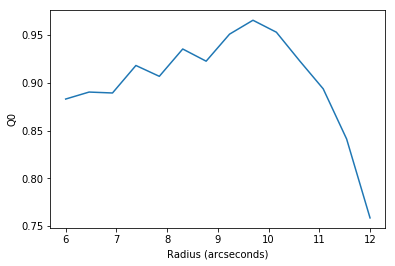

In [59]:
x = search_rad_r
y = Q0_r
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()

In [60]:
#select the maximum value of Q0 and the corresponding radius to use for the liklihood ratio crossmatch 
Q0 = max(Q0_r)
search_rad = search_rad_r[Q0_r == Q0][0]

In [5]:
Q0 = 0.6974
search_rad = 6.0

###### crossmatch
perform the liklihood ratio crossmatching using the optimal Q0 and radius found above the positional errors in the masterlist are hard to compute because the masterlist has been compiled as a combination of several other catalogues. So i have assumed an error of 1 arcsecond. This will create a systematic bias in the liklihood of the crossmatches. However the cutoff threshold to select good matches is dynamic so this shouldn't create a problem.

cut down the catalogues using the moc given (or with a rectangular area if no moc is given)

In [61]:
ra_down, ra_up, dec_down, dec_up = min(lofar_data['RA']),max(lofar_data['RA']),min(lofar_data['DEC']),max(lofar_data['DEC'])
field = Field(ra_down, ra_up, dec_down, dec_up, MHz150_MOC)

field area is defined by a MOC


In [62]:
# Filter the radio catalogue with the field
radio = field.filter_catalogue(lofar_data, colnames=('RA','DEC'))
print('number of radio sources being crossmatched is {}'.format(len(radio)))

filtering in a MOC
number of radio sources being crossmatched is 2551


In [63]:
# Filter the masterlist with the field
masterlist = field.filter_catalogue(lockman_data, colnames=('ra','dec'))
print('number of masterlist sources being crossmatched too is {}'.format(len(masterlist)))

filtering in a MOC
number of masterlist sources being crossmatched too is 2964418


In [64]:
coords_masterlist = SkyCoord(masterlist['ra'], 
                           masterlist['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

coords_radio = SkyCoord(radio['RA'], 
                       radio['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

catalogue_i = masterlist
catalogue_i['m_irac_i1'][np.isnan(catalogue_i['m_irac_i1'])] = 0


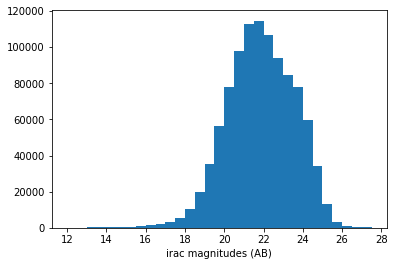

In [65]:
y = catalogue_i['m_irac_i1']
bins = np.arange(12,28,0.5)
plt.hist(y,bins=bins)
plt.xlabel('irac magnitudes (AB)')
plt.show()

In [66]:
bin_list_i = np.arange(12., 28., 0.5) # Bins of 0.5

center_i = get_center(bin_list_i)
# get the mid point of each bin i.e if there is a bin from 1 to 4 then the centre will be at 2.5

n_m_i = get_n_m(catalogue_i['m_irac_i1'], bin_list_i, field.area)
# get a cumulative distribution of the magnitudes divided by the field area
q_m_i = estimate_q_m(catalogue_i['m_irac_i1'], bin_list_i, n_m_i, coords_radio, coords_masterlist, radius=search_rad)

In [67]:
3923*np.pi*2.93E-7*(5/3600)**2

6.965796910010799e-09

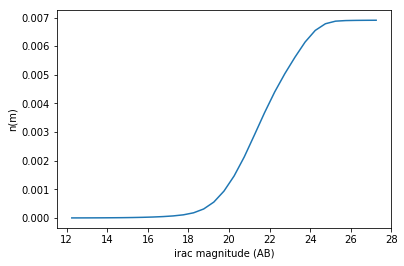

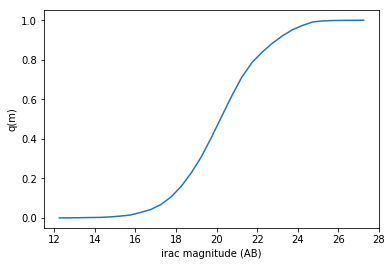

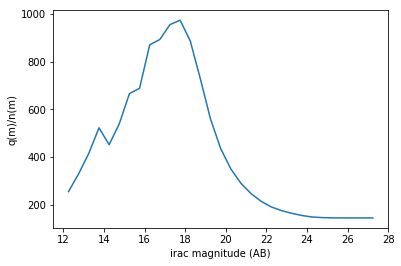

In [68]:
plt.plot(center_i,n_m_i)
plt.xlabel('irac magnitude (AB)')
plt.ylabel('n(m)')
plt.show()
plt.plot(center_i,q_m_i)
plt.xlabel('irac magnitude (AB)')
plt.ylabel('q(m)')
plt.show()
plt.plot(center_i,q_m_i/n_m_i)
plt.xlabel('irac magnitude (AB)')
plt.ylabel('q(m)/n(m)')
plt.show()

### $Q_0$ and likelihood estimators

In [69]:
Q0 = Q0
likelihood_ratio_i = SingleMLEstimator(Q0, n_m_i, q_m_i, center_i)
     
idx_radio, idx_i, d2d, d3d = search_around_sky(
    coords_radio, coords_masterlist, search_rad*u.arcsec)
    
idx_radio_unique = np.unique(idx_radio)

radio["lr_i"] = np.nan                   # Likelihood ratio
radio["lr_dist_i"] = np.nan              # Distance to the selected source
radio["lr_index_i"] = np.nan             # Index of the source in masterlist
    
total_sources = len(idx_radio_unique)
masterlist_aux_index = np.arange(len(masterlist))

In [70]:
# Function to calculate the crossmatch with the greatest liklihood ratio
def ml(i):
        
    idx_0 = idx_i[idx_radio == i]
    
    d2d_0 = d2d[idx_radio == i]
    
    i_mag = catalogue_i['m_irac_i1'][idx_0]
    print(i_mag)
    print(catalogue_i['f_irac_i1'][idx_0])
        
        
    radio_ra = radio[i]["RA"]
    radio_dec = radio[i]["DEC"]
    radio_pa = radio[i]["PA"]
    radio_maj_err = radio[i]["E_Maj"]
    radio_min_err = radio[i]["E_Min"]
    c_ra = catalogue_i["ra"][idx_0]
    c_dec = catalogue_i["dec"][idx_0]
    # Error for masterlist given as the true error is difficult to compute due to the 
    # composite nature of the masterlist
    c_ra_err = 1/3600
    c_dec_err = 1/3600
    helpids = catalogue_i['help_id'][idx_0]
        
    sigma = get_sigma(radio_maj_err, radio_min_err, radio_pa, 
                          radio_ra, radio_dec, 
                          c_ra, c_dec, c_ra_err, c_dec_err)
        
    lr_0 = likelihood_ratio_i(i_mag, d2d_0.arcsec, sigma)
        
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan]
        return result,np.nan,np.nan
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0))
    result = [masterlist_aux_index[idx_0[chosen_index]], # Index
                  (d2d_0.arcsec)[chosen_index],              # distance
                  lr_0[chosen_index]]                        # LR
    helpid = catalogue_i

    
    return (result,rel[chosen_index],helpid)

In [71]:
print('starting the crossmatch')
res = []
rel = []
helpid = []
nomatches = 0
for i in range(len(radio)):
    result,reliab,helid = ml(i)
    if result == [np.nan,np.nan,np.nan]:
        nomatches = nomatches + 1
        continue
    res.append(result)
    rel.append(reliab)
    helpid.append(helid)

starting the crossmatch
    m_irac_i1     
------------------
21.737240063397174
               0.0
               0.0
  21.4799607150159
f_irac_i1
---------
     7.33
      nan
      nan
     9.29
    m_irac_i1     
------------------
19.505371640786045
21.066951358168758
               0.0
18.929160110359867
19.173668020180635
f_irac_i1
---------
    57.26
    13.59
      nan
    97.35
    77.72
    m_irac_i1     
------------------
               0.0
18.981247063192903
               0.0
               0.0
f_irac_i1
---------
      nan
    92.79
      nan
      nan
    m_irac_i1     
------------------
               0.0
21.053453915251275
               0.0
20.469101043689186
               0.0
               0.0
               0.0
 20.43911646465623
f_irac_i1
---------
      nan
    13.76
      nan
    23.57
      nan
      nan
      nan
    24.23
    m_irac_i1     
------------------
 21.27986706721098
               0.0
19.773017400870167
               0.0
f_irac_i1
---------
 

    m_irac_i1     
------------------
               0.0
               0.0
               0.0
19.887815573618404
  20.1109776269138
f_irac_i1
---------
      nan
      nan
      nan
    40.26
    32.78
    m_irac_i1     
------------------
16.832796620366516
               0.0
               0.0
18.108477744732333
19.600040681808558
   f_irac_i1    
----------------
 671.24544532739
             nan
             nan
 207.30458238549
52.4787796434061
    m_irac_i1    
-----------------
              0.0
              0.0
22.21055414581479
              0.0
f_irac_i1
---------
      nan
      nan
     4.74
      nan
    m_irac_i1    
-----------------
              0.0
              0.0
              0.0
18.15190638648442
18.17086109119456
              0.0
              0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
199.176201383338
 195.72917408546
             nan
             nan
    m_irac_i1     
------------------
               0.0
     

    m_irac_i1     
------------------
               0.0
24.481810967297683
18.649635193114754
 21.76387992489412
    f_irac_i1    
-----------------
              nan
0.585161322917307
 125.934848124808
 7.15233800322779
    m_irac_i1     
------------------
21.462662237963592
               0.0
 23.36059287252801
               0.0
               0.0
 18.97604756056696
               0.0
  22.6537542385909
   f_irac_i1    
----------------
9.43919818936366
             nan
1.64347404964648
             nan
             nan
  93.23542949585
             nan
3.15136207762066
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
 20.58306019977406
 21.02268278205039
               0.0
               0.0
               0.0
 20.26403133213261
               0.0
20.129546701144697
               0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
21.2214922886566
 14.155554532739
             nan
             nan

    m_irac_i1    
-----------------
20.12162871127446
              0.0
              0.0
f_irac_i1
---------
    32.46
      nan
      nan
    m_irac_i1     
------------------
               0.0
               0.0
21.591889953424307
               0.0
               0.0
               0.0
               0.0
f_irac_i1
---------
      nan
      nan
     8.38
      nan
      nan
      nan
      nan
    m_irac_i1     
------------------
  24.0821497557774
               0.0
               0.0
22.604271079472433
               0.0
 21.48497747814347
               0.0
19.578638903772934
               0.0
    f_irac_i1    
-----------------
0.845551564986166
              nan
              nan
 3.29831073455272
              nan
 9.24717355517983
              nan
 53.5234918029511
              nan
    m_irac_i1     
------------------
               0.0
19.860738158634682
               0.0
               0.0
17.249270199976117
               0.0
               0.0
   f_irac_i1   
-----

    m_irac_i1     
------------------
21.358810857069166
23.866462788682576
22.030922221542546
24.324829617073412
 23.78509946288802
 25.92106589484299
    f_irac_i1    
-----------------
 10.3866538210882
 1.03137092576084
 5.59282346695358
0.676189080387335
 1.11162988764218
0.155443885013833
    m_irac_i1     
------------------
24.421032180911077
               0.0
               0.0
19.187338607860333
19.913568509202996
20.972147122429043
 22.88838082143264
               0.0
    f_irac_i1    
-----------------
0.618852468536735
              nan
              nan
 76.7475564325238
 39.3162960221334
            14.83
 2.53891213541346
              nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
19.825711668382176
               0.0
 20.02687860786485
               0.0
               0.0
 19.24109808868439
f_irac_i1
---------
      nan
      nan
      nan
    42.63
      nan
    35.42
      nan
      nan
    73.04
    m_irac_i1  

    m_irac_i1    
-----------------
              0.0
              0.0
16.74030419546559
              0.0
              0.0
17.28905125559178
              0.0
              0.0
              0.0
              0.0
   f_irac_i1    
----------------
             nan
             nan
730.934265739317
             nan
             nan
          440.94
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
19.957731690562788
               0.0
17.440345813067687
               0.0
               0.0
   f_irac_i1    
----------------
37.7491627543806
             nan
383.585052044267
             nan
             nan
    m_irac_i1     
------------------
19.300833607793912
               0.0
               0.0
               0.0
               0.0
 19.09747549625741
 24.80346007683655
               0.0
               0.0
19.706667121450245
16.623594509103164
               0.0
24.532624595526094
               0.0
               0.0
 19.5

    m_irac_i1     
------------------
24.839446859579574
 20.45044660751835
21.715848533487296
22.509354570719573
               0.0
 24.70346043739105
    f_irac_i1    
-----------------
0.420941026867507
 23.9784638426068
 7.47585013356901
 3.59963256163541
              nan
0.477107040178297
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
17.691382147891083
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
             nan
             nan
304.401747187212
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
18.920900525716426
 19.89668242159177
               0.0
               0.0
 17.73674679983217
   f_irac_i1    
----------------
 98.093400430372
39.9325488272364
             nan
             nan
2

    m_irac_i1    
-----------------
              0.0
 20.8505535564233
23.66225757832526
              0.0
   f_irac_i1    
----------------
             nan
16.5874099216108
1.24479251629265
             nan
    m_irac_i1     
------------------
               0.0
18.874454036853685
               0.0
 22.50948900133718
23.685908116836806
   f_irac_i1    
----------------
             nan
102.380768521365
             nan
3.59918690009222
1.21797045434983
    m_irac_i1     
------------------
20.394504094492554
               0.0
  22.2121692449904
               0.0
  21.6254819604547
21.388656124535693
               0.0
 24.88743971824197
    f_irac_i1    
-----------------
 25.2463362511528
              nan
 4.73295420119889
              nan
   8.124697791577
 10.1050286735321
              nan
0.402739394420535
    m_irac_i1     
------------------
               0.0
21.769165687826494
23.285195714314774
               0.0
               0.0
               0.0
 21.199518238880

    m_irac_i1     
------------------
17.971212786715903
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
235.242012050415
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
20.067795701481508
               0.0
               0.0
 19.78035477760657
18.437811078023636
 19.55821216598597
   f_irac_i1    
----------------
             nan
             nan
             nan
           34.11
             nan
             nan
44.4486002490009
153.064884737166
           54.54
    m_irac_i1     
------------------
 22.57000450282785
25.401000774961027
               0.0
               0.0
               0.0
    f_irac_i1    
-----------------
 3.40406777943437
0.250957217245619
              nan
              nan
              nan
    m_irac_i1     
------------------
20.689841263372706


    m_irac_i1     
------------------
               0.0
               0.0
               0.0
14.864130698002064
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
4114.79042714417
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
               0.0
 20.67327628103684
               0.0
               0.0
22.107905691751192
               0.0
               0.0
               0.0
               0.0
22.488334839369777
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
19.5294263910237
             nan
             nan
            5.21
             nan
             nan
             nan
             nan
            3.67
             nan
             nan
             nan
       

    f_irac_i1    
-----------------
              nan
              nan
              nan
              nan
 31.6435736012911
              nan
 66.4396910636336
              nan
              nan
              nan
              nan
              nan
 20.6202046941285
 1.47022615939133
0.844771657285582
    m_irac_i1     
------------------
22.673162621584787
26.249688758986075
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
 20.47807182081778
 24.31853446416597
 20.49625427069622
    f_irac_i1    
-----------------
 3.09552953012604
0.114848280249001
              nan
              nan
              nan
              nan
              nan
              nan
              nan
 23.3760577589917
 0.68012104640332
 22.9878466707654
    m_irac_i1     
------------------
22.614344822249713
               0.0
19.157081329723034
  19.1663323327896
               0.0
   f_irac_i1    
----------------
3.2678496

    m_irac_i1     
------------------
 21.85120158102834
               0.0
 19.67320856464257
19.800957235681047
               0.0
 21.13228419931921
21.370017213351865
20.662208047017735
 21.69463519509572
   f_irac_i1    
----------------
6.59962664986167
             nan
49.0587608223179
43.6131149123886
             nan
12.7963561896711
           10.28
19.7295318920996
7.62335109867814
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
18.640638838221882
               0.0
 27.32854996185386
    f_irac_i1     
------------------
               nan
               nan
               nan
               nan
  126.982672978789
               nan
0.0425187036873655
    m_irac_i1     
------------------
               0.0
               0.0
18.171137679592256
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
             nan
195.679318951737
             nan
        

    m_irac_i1     
------------------
               0.0
               0.0
17.341618296155026
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
f_irac_i1
---------
      nan
      nan
    420.1
      nan
      nan
      nan
      nan
      nan
      nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
18.545967228822754
               0.0
               0.0
               0.0
               0.0
 20.13339923608374
19.818800702775185
17.840522144979737
 19.21706903733189
               0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
             nan
138.552098662773
             nan
             nan
             nan
             nan
           32.11
42.9022153873348
 265.33292337842
74.6745106086689
             nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
18.2924669

    m_irac_i1     
------------------
24.637696983609324
18.800693006766686
               0.0
 21.12531924183765
    f_irac_i1    
-----------------
0.506898733999385
 109.577855625576
              nan
  12.878708200123
    m_irac_i1     
------------------
               0.0
 21.55853560579242
               0.0
 22.38179823975714
               0.0
               0.0
19.684419014107227
               0.0
   f_irac_i1    
----------------
             nan
8.64143281340301
             nan
4.04837471856748
             nan
             nan
48.5548251306486
             nan
    m_irac_i1     
------------------
               0.0
19.193080622201073
               0.0
23.511445645479675
               0.0
   f_irac_i1    
----------------
             nan
76.3427414171534
             nan
1.43028222625269
             nan
    m_irac_i1     
------------------
23.227907059073054
 21.79321596613986
23.058098377202434
 20.76118865945019
               0.0
               0.0
   f_irac_i1  

    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
18.995640516022597
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
19.630049894128952
18.582951829622424
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
             nan
             nan
             nan
91.5680137104211
             nan
             nan
             nan
             nan
             nan
             nan
             nan
51.0481540670151
133.911929634184
             nan
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
               0.0
               0.0
18.368765341670404
               0.0
               0.0
   

    m_irac_i1    
-----------------
22.55601765981401
              0.0
              0.0
21.84507403586168
24.46289569825877
    f_irac_i1    
-----------------
 3.44820387903474
              nan
              nan
 6.63697811604673
0.595445093083308
    m_irac_i1    
-----------------
              0.0
              0.0
17.37593395019062
              0.0
f_irac_i1
---------
      nan
      nan
   407.03
      nan
    m_irac_i1     
------------------
21.098599347614957
               0.0
17.951197902043468
               0.0
 20.61639070237299
               0.0
               0.0
20.459578982904596
               0.0
   f_irac_i1    
----------------
13.1995845112204
             nan
239.618772563787
             nan
20.5799217460805
             nan
             nan
23.7776213525976
             nan
    m_irac_i1     
------------------
22.527373057828534
               0.0
 18.25257817006365
               0.0
               0.0
22.270127824536566
20.948355625152082
             

    m_irac_i1     
------------------
               0.0
18.837617666763144
               0.0
               0.0
18.573217056970684
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
105.913893467568
             nan
             nan
135.117990347372
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
22.187274747504837
21.027877748280623
 23.63281989550557
   f_irac_i1    
----------------
4.84272826928989
14.0879856532432
1.27900440962189
    m_irac_i1     
------------------
               0.0
               0.0
 19.47176639342735
               0.0
               0.0
               0.0
               0.0
20.272453869611347
18.396643768380734
               0.0
20.232830949114735
               0.0
               0.0
               0.0
f_irac_i1
---------
      nan
      nan
    59.06
      nan
      nan
      nan
    

    m_irac_i1     
------------------
               0.0
               0.0
17.284949132462152
               0.0
15.980658942636417
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
             nan
442.609108438365
             nan
1471.41921441746
             nan
             nan
             nan
             nan
             nan
             nan
    m_irac_i1    
-----------------
              0.0
              0.0
              0.0
16.25259100645345
              0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
1145.41692852751
             nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
19.604368749755615
18.591105854990126
               0.0
 20.87755370680936
20.033334937324533
               0.0
f_irac_i1
---------
      nan
      nan
      nan
    52.27
   132.91
      na

    m_irac_i1     
------------------
 19.79854798377587
               0.0
               0.0
               0.0
21.131975075880327
               0.0
20.074821077906556
 21.92781221056145
               0.0
f_irac_i1
---------
    43.71
      nan
      nan
      nan
     12.8
      nan
    33.89
     6.15
      nan
    m_irac_i1    
-----------------
              0.0
              0.0
              0.0
              0.0
18.47576926301479
              0.0
              0.0
              0.0
   f_irac_i1    
----------------
             nan
             nan
             nan
             nan
147.806078527513
             nan
             nan
             nan
    m_irac_i1     
------------------
               0.0
               0.0
23.468428972248027
 23.21041840704654
               0.0
21.066347657360502
   f_irac_i1    
----------------
             nan
             nan
1.48808730295112
1.88726391945896
             nan
13.5975585351983
    m_irac_i1     
------------------
22.52

    m_irac_i1    
-----------------
              0.0
19.11608584538711
              0.0
22.48170227880913
   f_irac_i1    
----------------
             nan
81.9531520411927
             nan
3.69248796495543
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
  20.6705715906486
               0.0
23.016376334425765
   f_irac_i1    
----------------
             nan
             nan
             nan
19.5781370242853
             nan
2.25657340916077
    m_irac_i1     
------------------
               0.0
20.399518778518562
 19.68229288848908
               0.0
               0.0
f_irac_i1
---------
      nan
    25.13
    48.65
      nan
      nan
    m_irac_i1     
------------------
               0.0
21.147351612729715
20.176525508186977
               0.0
20.982264054314733
20.706082455706515
21.535228995820127
               0.0
21.716664066536957
   f_irac_i1    
----------------
             nan
           12.62
30.8595647740547
     

    m_irac_i1     
------------------
               0.0
               0.0
20.926274215751583
 20.90198380209585
               0.0
               0.0
18.934078516074315
               0.0
 21.32552632292036
20.118622517739475
 21.57008471317956
f_irac_i1
---------
      nan
      nan
    15.47
    15.82
      nan
      nan
    96.91
      nan
    10.71
    32.55
     8.55
m_irac_i1
---------
      0.0
      0.0
      0.0
      0.0
      0.0
f_irac_i1
---------
      nan
      nan
      nan
      nan
      nan
    m_irac_i1     
------------------
               0.0
20.831961932082386
21.577213883659475
               0.0
 21.93134544214238
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
             nan
16.8738905256686
8.49404283015678
             nan
6.13001903565939
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
23.6277450847

    m_irac_i1     
------------------
21.793476900973594
               0.0
               0.0
 22.89649864804614
22.703583761015388
               0.0
f_irac_i1
---------
     6.96
      nan
      nan
     2.52
     3.01
      nan
    m_irac_i1     
------------------
               0.0
21.506214129257536
21.000586195493163
19.338849573338912
               0.0
22.672963447479965
               0.0
   f_irac_i1    
----------------
             nan
9.06805923301568
14.4465957977252
66.7513680187519
             nan
3.09609744512757
             nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
17.547737961707462
               0.0
               0.0
               0.0
               0.0
               0.0
21.082238004087976
f_irac_i1
---------
      nan
      nan
      nan
      nan
      nan
      nan
   347.46
      nan
      nan
      nan
      nan
      nan
     13.4
    m_ira

    m_irac_i1     
------------------
21.719609318129265
               0.0
   22.109991640913
               0.0
               0.0
               0.0
f_irac_i1
---------
     7.45
      nan
      5.2
      nan
      nan
      nan
    m_irac_i1    
-----------------
22.19238240440287
              0.0
              0.0
f_irac_i1
---------
     4.82
      nan
      nan
    m_irac_i1     
------------------
20.854317866071376
               0.0
21.653187046026268
19.517575337427296
               0.0
f_irac_i1
---------
    16.53
      nan
     7.92
    56.62
      nan
    m_irac_i1     
------------------
               0.0
               0.0
17.752235301281978
f_irac_i1
---------
      nan
      nan
   287.81
    m_irac_i1     
------------------
               0.0
16.974656463784946
15.827371262800817
16.564776965779394
               0.0
               0.0
               0.0
   f_irac_i1   
---------------
            nan
         589.03
1694.5387122656
         859.19
            n

    m_irac_i1     
------------------
               0.0
17.434375902834894
               0.0
               0.0
f_irac_i1
---------
      nan
    385.7
      nan
      nan
    m_irac_i1     
------------------
               0.0
15.821523564324217
               0.0
               0.0
               0.0
               0.0
               0.0
f_irac_i1
---------
      nan
  1703.69
      nan
      nan
      nan
      nan
      nan
    m_irac_i1     
------------------
 21.07015176197394
               0.0
               0.0
 18.12722431834134
               0.0
21.939529204076514
   f_irac_i1    
----------------
           13.55
             nan
             nan
203.755937319397
             nan
6.08398757393175
    m_irac_i1     
------------------
23.853575795012397
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
1.0436855773132

    m_irac_i1     
------------------
20.114294880349057
               0.0
               0.0
               0.0
               0.0
f_irac_i1
---------
    32.68
      nan
      nan
      nan
      nan
m_irac_i1
---------
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
f_irac_i1
---------
      nan
      nan
      nan
      nan
      nan
      nan
      nan
      nan
      nan
      nan
    m_irac_i1     
------------------
               0.0
               0.0
 19.46827911329465
20.399518778518562
               0.0
18.842898472808677
               0.0
               0.0
               0.0
 18.86338368828992
21.705132620927024
               0.0
               0.0
f_irac_i1
---------
      nan
      nan
    59.25
    25.13
      nan
    105.4
      nan
      nan
      nan
   103.43
     7.55
      nan
      nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
        

    m_irac_i1    
-----------------
              0.0
              0.0
              0.0
              0.0
19.47121502505083
              0.0
20.86554175166173
f_irac_i1
---------
      nan
      nan
      nan
      nan
    59.09
      nan
    16.36
    m_irac_i1    
-----------------
              0.0
              0.0
              0.0
              0.0
16.33170754127564
20.18747196355357
              0.0
f_irac_i1
---------
      nan
      nan
      nan
      nan
  1064.92
    30.55
      nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
 19.97744353492609
16.659235731334796
               0.0
f_irac_i1
---------
      nan
      nan
      nan
      nan
      nan
      nan
      nan
      nan
      nan
      nan
    37.07
    787.6
      nan
    m_irac_i1     
------------------
21.672551007525776
    

    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
21.940241051818155
f_irac_i1
---------
      nan
      nan
      nan
      nan
      nan
     6.08
    m_irac_i1     
------------------
21.651817031705995
               0.0
               0.0
19.583950149286714
 20.83283985306425
 20.57548869458983
               0.0
               0.0
               0.0
               0.0
               0.0
   f_irac_i1    
----------------
            7.93
             nan
             nan
53.2623029249923
16.8602518951737
           21.37
             nan
             nan
             nan
             nan
             nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
15.214787296242953
               0.0
               0.0
f_irac_i1
---------
      nan
      nan
      nan
      nan
   2979.1
      nan
      nan
    m_irac_i1     
------------------
 

    m_irac_i1     
------------------
22.564776553532916
               0.0
19.779776106012683
               0.0
 20.70371966702887
               0.0
22.026985968799117
               0.0
               0.0
20.573513021583643
   f_irac_i1    
----------------
3.42049829741777
             nan
44.4722966108208
             nan
18.9894389348294
             nan
5.61313661604673
             nan
             nan
21.4089215800799
    m_irac_i1     
------------------
               0.0
 20.34763648519506
18.630279937043007
               0.0
f_irac_i1
---------
      nan
    26.36
    128.2
      nan
    m_irac_i1     
------------------
               0.0
               0.0
13.691868017930403
f_irac_i1
---------
      nan
      nan
 12113.03
    m_irac_i1    
-----------------
              0.0
18.72509015537309
21.55997301071198
f_irac_i1
---------
      nan
   117.48
     8.63
    m_irac_i1     
------------------
               0.0
23.785509415346745
               0.0
22.55163221143

    m_irac_i1     
------------------
               0.0
19.338383963204116
               0.0
               0.0
               0.0
               0.0
20.655051889601587
f_irac_i1
---------
      nan
    66.78
      nan
      nan
      nan
      nan
    19.86
    m_irac_i1     
------------------
21.631471598063534
               0.0
 21.65044874393225
21.915524038272956
               0.0
               0.0
20.024429117362267
               0.0
               0.0
20.746842828018764
21.833193699577514
 20.50516288249886
               0.0
f_irac_i1
---------
     8.08
      nan
     7.94
     6.22
      nan
      nan
     35.5
      nan
      nan
    18.25
     6.71
     22.8
      nan
    m_irac_i1     
------------------
               0.0
21.474132809424766
 21.87273929832825
               0.0
f_irac_i1
---------
      nan
     9.34
     6.47
      nan
    m_irac_i1     
------------------
               0.0
               0.0
21.140490697610097
 19.86883509011715
               0

    m_irac_i1     
------------------
               0.0
16.233877682550435
19.542598324464613
               0.0
               0.0
               0.0
               0.0
f_irac_i1
---------
      nan
  1165.33
    55.33
      nan
      nan
      nan
      nan
    m_irac_i1     
------------------
               0.0
19.440776909131706
               0.0
               0.0
f_irac_i1
---------
      nan
    60.77
      nan
      nan
    m_irac_i1     
------------------
               0.0
20.971415247642476
               0.0
19.907408337555857
               0.0
               0.0
               0.0
               0.0
21.013940067213376
               0.0
               0.0
               0.0
               0.0
               0.0
21.557459731337964
f_irac_i1
---------
      nan
    14.84
      nan
    39.54
      nan
      nan
      nan
      nan
    14.27
      nan
      nan
      nan
      nan
      nan
     8.65
    m_irac_i1     
------------------
18.176863979864542
               

m_irac_i1
---------
      0.0
      0.0
      0.0
f_irac_i1
---------
      nan
      nan
      nan
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
20.361314579726915
               0.0
               0.0
 20.70597696423976
20.503735221274418
               0.0
21.631471598063534
f_irac_i1
---------
      nan
      nan
      nan
      nan
      nan
    26.03
      nan
      nan
    18.95
    22.83
      nan
     8.08
m_irac_i1
---------
      0.0
      0.0
f_irac_i1
---------
      nan
      nan
    m_irac_i1     
------------------
 18.73325362394251
17.739782599052027
19.478959779459167
               0.0
               0.0
f_irac_i1
---------
    116.6
   291.13
    58.67
      nan
      nan
    m_irac_i1    
-----------------
              0.0
20.61902762657352
f_irac_i1
---------
      nan
    20.53
    m_irac_i1     
------------------
               0.0
               0.0
               0.0
    

In [72]:
print('number of sources with no possible match is {}'.format(nomatches))
    
(radio["lr_index_i"][idx_radio_unique], 
radio["lr_dist_i"][idx_radio_unique], 
radio["lr_i"][idx_radio_unique]) = list(map(list, zip(*res)))

number of sources with no possible match is 1


In [73]:
radio["lr_i"][np.isnan(radio["lr_i"])] = 0
    
threshold_i = np.percentile(radio[radio['lr_i'] !=0]["lr_i"], 100*(1 - Q0))
print('liklihood ratio threshold using Q0 only is {}'.format(threshold_i))

liklihood ratio threshold using Q0 only is 8.887837817719514e-85


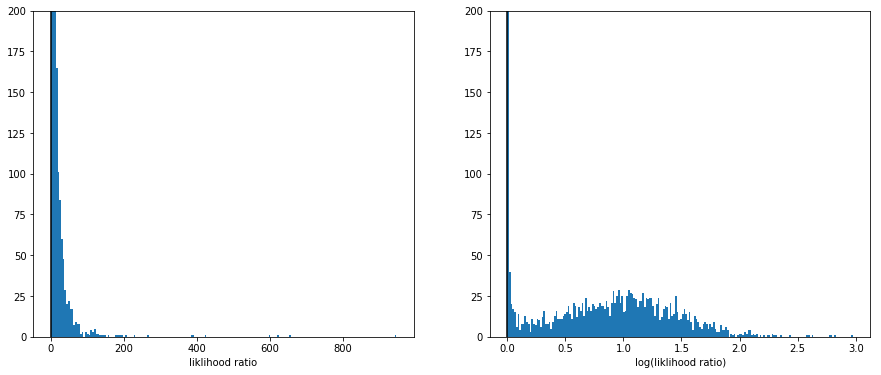

In [74]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(radio[radio["lr_i"] != 0]["lr_i"], bins=200)
plt.vlines([threshold_i], 0, 1000)
plt.xlabel('liklihood ratio')
plt.ylim([0,200])
plt.subplot(1,2,2)
plt.hist(np.log10(radio[radio["lr_i"] != 0]["lr_i"]+1), bins=200)
plt.vlines(np.log10(threshold_i+1), 0, 1000)
plt.ylim([0,200]);
plt.xlabel('log(liklihood ratio)')
plt.show()

In [75]:
radio["lrt"] = radio["lr_i"]
radio["lrt"][np.isnan(radio["lr_i"])] = 0

In [76]:
print('updating threshold of liklihood ratio that can be trusted')      
def completeness(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr < threshold]
    return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    
def reliability(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr > threshold]
    return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/(float(n)*q0)

updating threshold of liklihood ratio that can be trusted


In [77]:
completeness_v = np.vectorize(completeness, excluded=[0])
reliability_v = np.vectorize(reliability, excluded=[0])
    
n_test = 100
threshold_mean = np.percentile(radio["lrt"], 100*(1 - Q0))
    
thresholds = np.arange(0., 10., 0.01)
thresholds_fine = np.arange(0.1, 1., 0.001)
    
completeness_t = completeness_v(radio["lrt"], thresholds, Q0)
reliability_t = reliability_v(radio["lrt"], thresholds, Q0)
average_t = (completeness_t + reliability_t)/2
    
completeness_t_fine = completeness_v(radio["lrt"], thresholds_fine, Q0)
reliability_t_fine = reliability_v(radio["lrt"], thresholds_fine, Q0)
average_t_fine = (completeness_t_fine + reliability_t_fine)/2
    
threshold_sel = thresholds_fine[np.argmax(average_t_fine)]
print('liklihood ratio updated threshold considering completeness and reliability is {}'.format(threshold_sel))

liklihood ratio updated threshold considering completeness and reliability is 0.1


/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


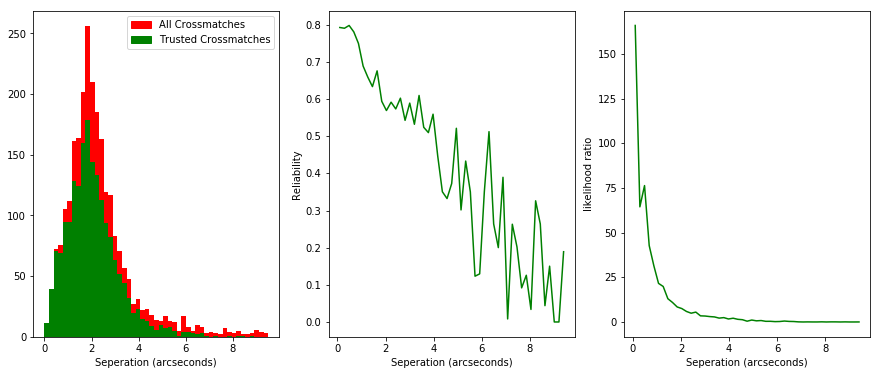

In [78]:
plt.rcParams["figure.figsize"] = (15,6)
bins = np.arange(0,search_rad,search_rad/50)
plt.subplot(1,3,1)
mask = ~np.isnan(radio['lr_dist_i'])
plt.hist(radio['lr_dist_i'][mask],bins=bins,color='red')
mask = (radio['lrt'] > threshold_sel) & (~np.isnan(radio['lr_dist_i']))
plt.hist(radio['lr_dist_i'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(radio['lr_dist_i']))
for n in range(len(bins)-1):
    mask = (radio['lr_dist_i'] > bins[n]) & (radio['lr_dist_i'] < bins[n+1])
    mask = mask[mask1]
    rel_temp = np.array(rel)[mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(radio['lr_dist_i']))
for n in range(len(bins)-1):
    mask = (radio['lr_dist_i'] > bins[n]) & (radio['lr_dist_i'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = radio['lrt'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')

plt.show()

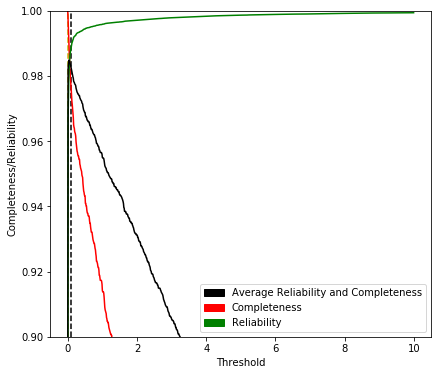

In [79]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.plot(thresholds, completeness_t, "r-")
plt.plot(thresholds, reliability_t, "g-")
plt.plot(thresholds, average_t, "k-")
plt.vlines(threshold_sel, 0.9, 1., "k", linestyles="dashed")
plt.vlines(threshold_mean, 0.9, 1., "y", linestyles="dashed")
plt.ylim([0.9, 1.])
plt.xlabel("Threshold")
plt.ylabel("Completeness/Reliability")
black_patch = mpatches.Patch(color='black',label='Average Reliability and Completeness')
green_patch = mpatches.Patch(color='green',label='Reliability')
red_patch = mpatches.Patch(color='red',label='Completeness')
plt.legend(handles=[black_patch,red_patch,green_patch])
plt.show()

In [80]:
print('creating masterlist table of cross matched sources')
radio_match = radio[~np.isnan(radio['lr_dist_i'])]
radio_match = radio_match[radio_match['lr_i']>threshold_sel]

lockman_match = masterlist[radio_match['lr_index_i'].quantity.value.astype(int)]
    
new_table = astropy.table.hstack([radio_match,lockman_match],join_type='outer')
print('number of crossmatched sources is {}'.format(len(new_table)))

creating masterlist table of cross matched sources
number of crossmatched sources is 1867


/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Text(0,0.5,'likelihood ratio')

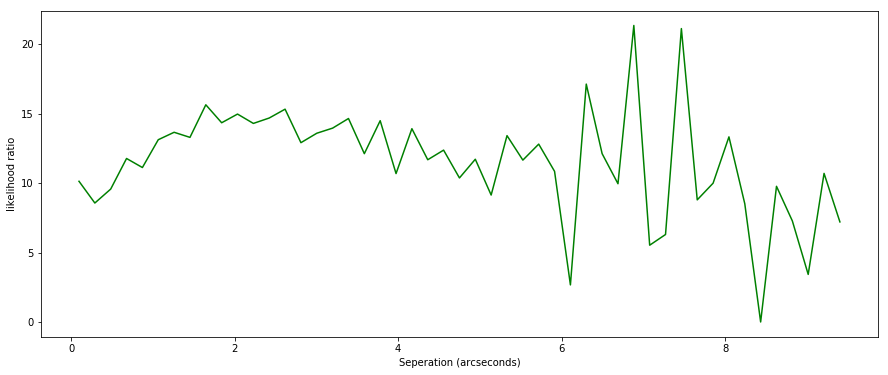

In [81]:
mag_r = []
mask1 = (~np.isnan(radio['lr_dist_i']))
for n in range(len(bins)-1):
    mask = (radio['lr_dist_i'] > bins[n]) & (radio['lr_dist_i'] < bins[n+1])
    id_temp = radio['lr_index_i'][mask].quantity.value.astype(int)
    mag_temp = catalogue_i[id_temp]['m_irac_i1']
    mag_r.append(np.mean(mag_temp))

rad_cent = get_center(bins)
plt.plot(rad_cent,mag_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')

In [ ]:
new_table[0]

In [ ]:
catalogue_i[4365644]

In [ ]:
# Demonstarting that the likelihood_ratio function has the same output as this notebook
cross_match_table = likelihood_ratio(lofar_data,lockman_data,'RA','DEC','ra','dec','m_irac_i1',Q0,search_rad,min(lofar_data['RA']),max(lofar_data['RA']),min(lofar_data['DEC']),max(lofar_data['DEC']),moc=MHz150_MOC)

In [ ]:
mask = ~np.isnan(cross_match_table['lrt'])
table_temp = cross_match_table[mask]
bins = np.arange(12,26,0.5)
y = []
for n in range(len(bins)-1):
    mask = (table_temp['m_irac_i1'] > bins[n]) & (table_temp['m_irac_i1'] < bins[n+1])
    lrt_temp = np.mean(table_temp['lrt'][mask])
    y.append(lrt_temp)
x = get_center(bins)

plt.plot(x,y)
plt.show()

In [ ]:
mask = ~np.isnan(cross_match_table['lrt'])
len(cross_match_table[mask])

In [ ]:
len(rel)

In [ ]:
radio